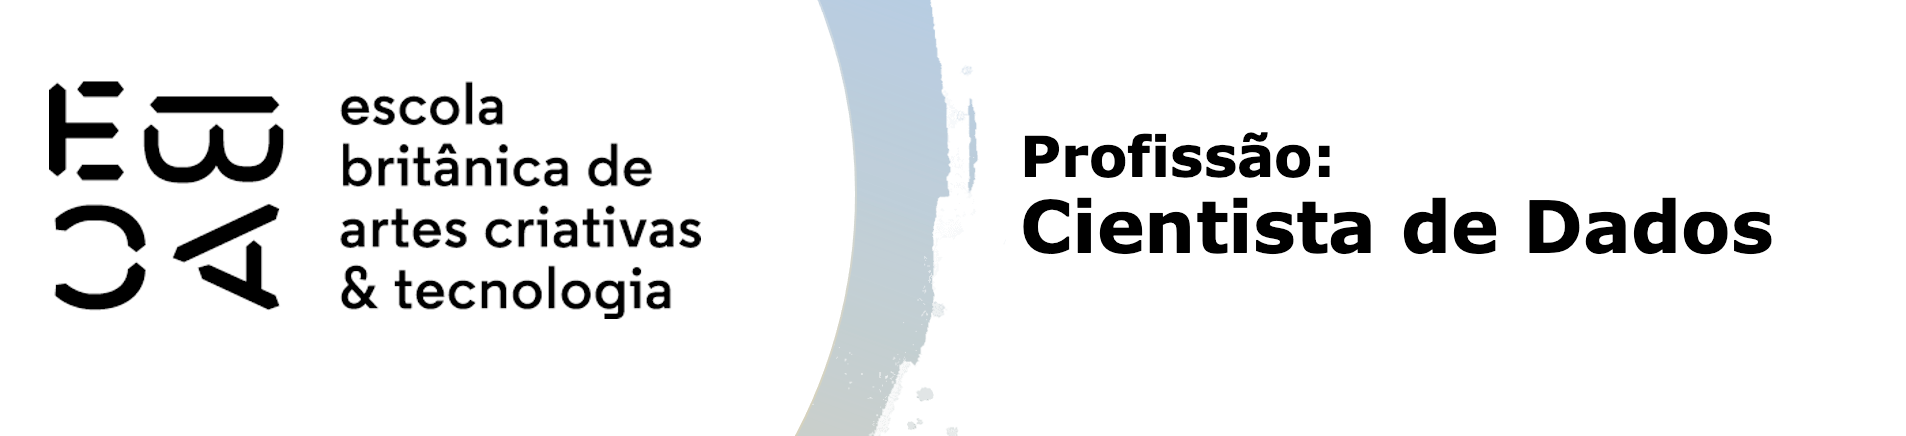

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df_base = pd.read_feather('./credit_scoring.ftr')
df_base.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
# Extraindo dados
df_base['mes'] = df_base['data_ref'].dt.month
df_base.head(5)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1


In [3]:
# Separando dados em base de treino e base de teste
df_test = df_base[(df_base['data_ref'].dt.year == 2016)].copy()
df_train = df_base[(df_base['data_ref'].dt.year == 2015)].copy()
df_test.head(5)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True,1
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False,1
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False,1
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False,1
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False,1


In [4]:
df_train.head(5)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
print(f'Número total de linhas: {df_train.shape[0]}')
print('Número de linhas por mês:')
print(df_train['mes'].value_counts().sort_index())

Número total de linhas: 600000
Número de linhas por mês:
mes
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: count, dtype: int64


In [6]:
# Funções para análise univariada
def analise_univariada(df, var):
    if df[var].nunique() <= 6:
        analise_qualitativa(df, var)
    else:
        analise_quantitativa(df, var)

def analise_qualitativa(df, var):
    tab = (pd.DataFrame(df[var].value_counts())
           .rename({'count': 'Frequência_Absoluta'},axis=1)
           .assign(Frequência_Relativa = df[var].value_counts(normalize=True)))
    
    print(tab)
    
    df[var].value_counts(normalize=True).plot(
        kind='bar',
        title='Frequência Relativa das Classes na Base de Dados',
        ylabel='Frequência Relativa')
    plt.show()

def analise_quantitativa(df, var):
    tab = (pd.DataFrame(df[var].describe())
           .rename({'count': 'Contagem',
                    'mean': 'Média',
                    'std': 'Desvio_Padrão',
                    'min': 'Valor_Mínimo','max': 
                    'Valor_Máximo'}, axis=0))

    print(tab)
    
    df[var].plot(kind='hist',
                 title='Histograma de {}'.format(var.capitalize()),
                 ylabel='Frequência Absoluta', 
                 xlabel=var)
    plt.show()

      Frequência_Absoluta  Frequência_Relativa
sexo                                          
F                  403805             0.673008
M                  196195             0.326992


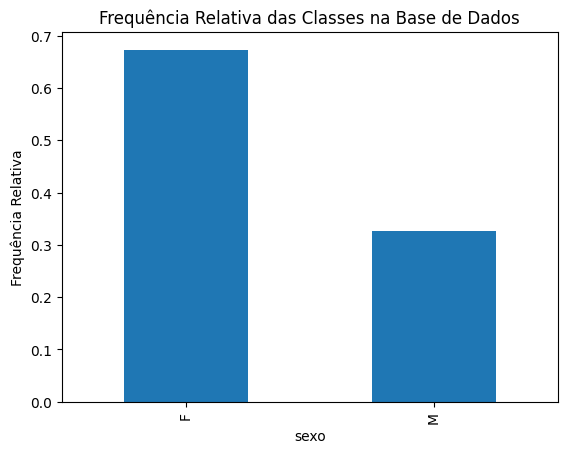

                  Frequência_Absoluta  Frequência_Relativa
posse_de_veiculo                                          
N                              366293             0.610488
S                              233707             0.389512


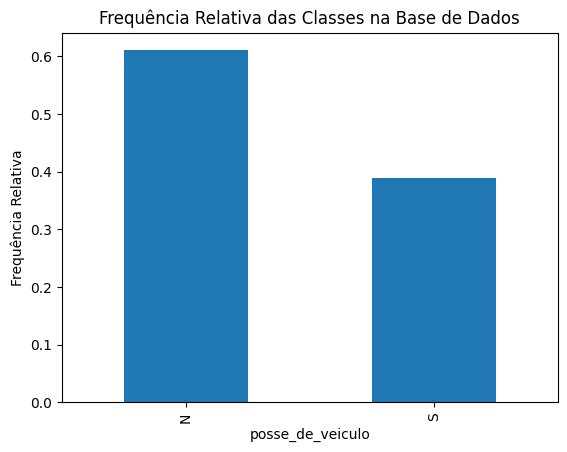

                 Frequência_Absoluta  Frequência_Relativa
posse_de_imovel                                          
S                             403054             0.671757
N                             196946             0.328243


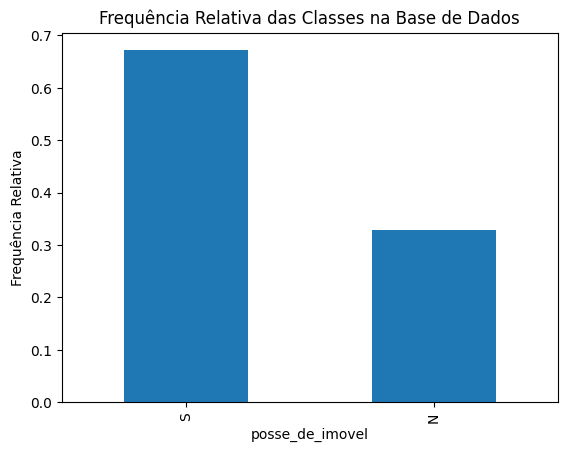

                  qtd_filhos
Contagem       600000.000000
Média               0.433210
Desvio_Padrão       0.739869
Valor_Mínimo        0.000000
25%                 0.000000
50%                 0.000000
75%                 1.000000
Valor_Máximo       14.000000


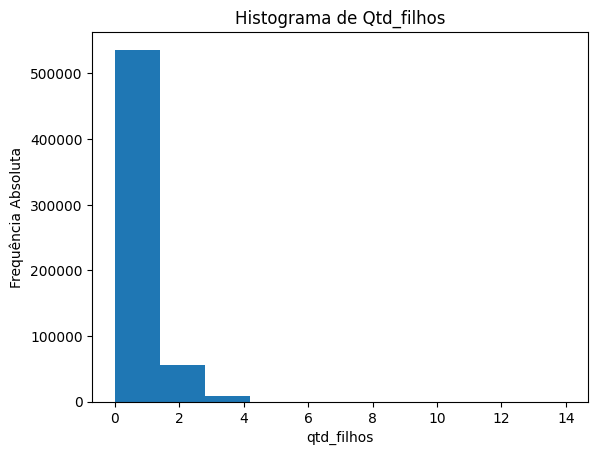

                  Frequência_Absoluta  Frequência_Relativa
tipo_renda                                                
Assalariado                    308460             0.514100
Empresário                     138141             0.230235
Pensionista                    101127             0.168545
Servidor público                51981             0.086635
Bolsista                          291             0.000485


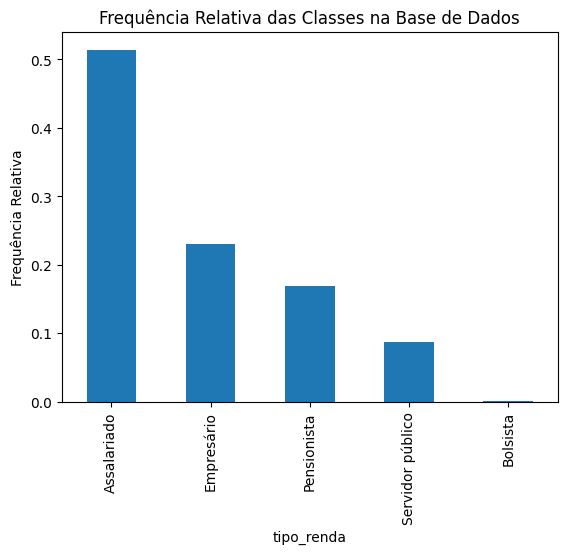

                     Frequência_Absoluta  Frequência_Relativa
educacao                                                     
Médio                             405449             0.675748
Superior completo                 163440             0.272400
Superior incompleto                23559             0.039265
Fundamental                         6901             0.011502
Pós graduação                        651             0.001085


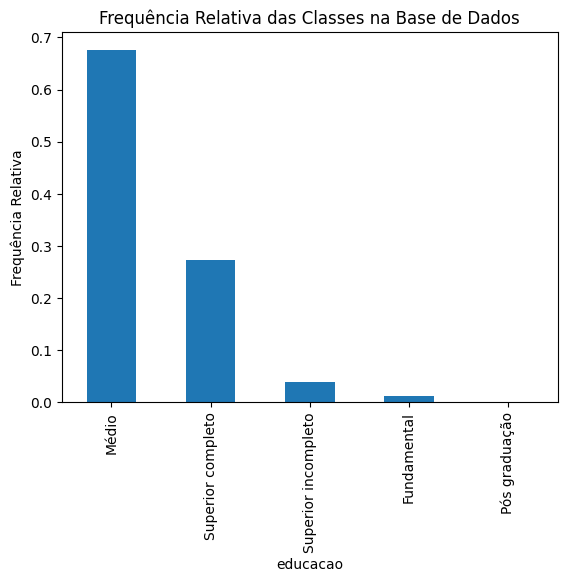

              Frequência_Absoluta  Frequência_Relativa
estado_civil                                          
Casado                     421149             0.701915
Solteiro                    73221             0.122035
União                       46108             0.076847
Separado                    34188             0.056980
Viúvo                       25334             0.042223


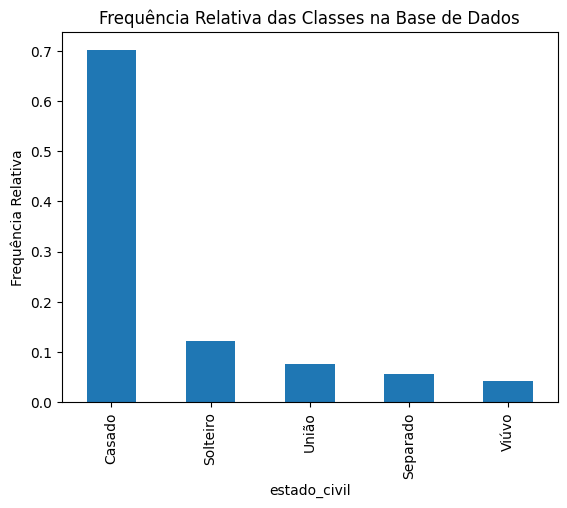

                 Frequência_Absoluta  Frequência_Relativa
tipo_residencia                                          
Casa                          539336             0.898893
Com os pais                    26730             0.044550
Governamental                  18742             0.031237
Aluguel                         8262             0.013770
Estúdio                         4296             0.007160
Comunitário                     2634             0.004390


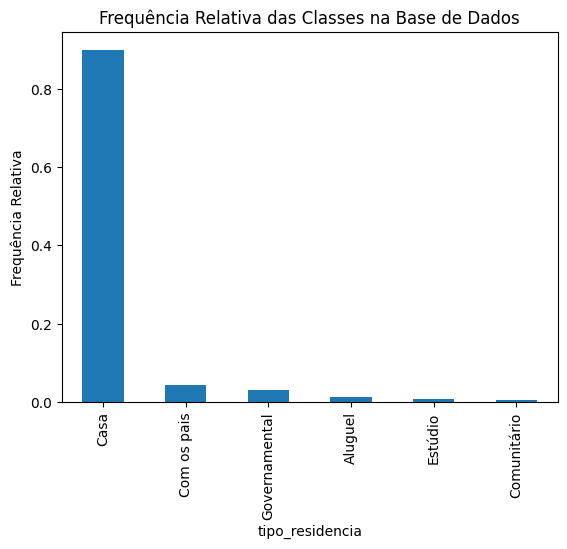

                       idade
Contagem       600000.000000
Média              43.798530
Desvio_Padrão      11.230659
Valor_Mínimo       22.000000
25%                34.000000
50%                43.000000
75%                53.000000
Valor_Máximo       68.000000


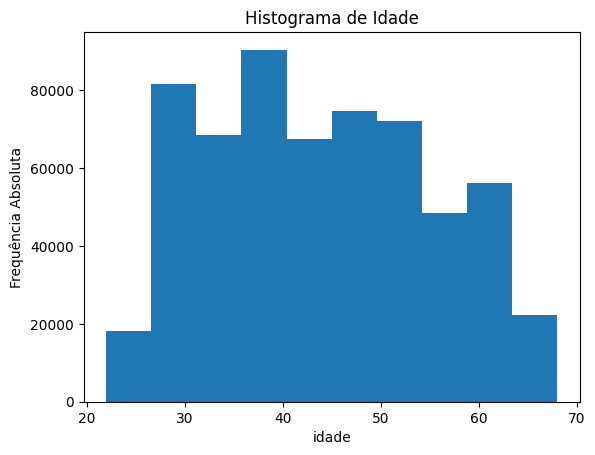

               tempo_emprego
Contagem       499125.000000
Média               7.747992
Desvio_Padrão       6.688576
Valor_Mínimo        0.117808
25%                 3.049315
50%                 6.046575
75%                10.180822
Valor_Máximo       42.906849


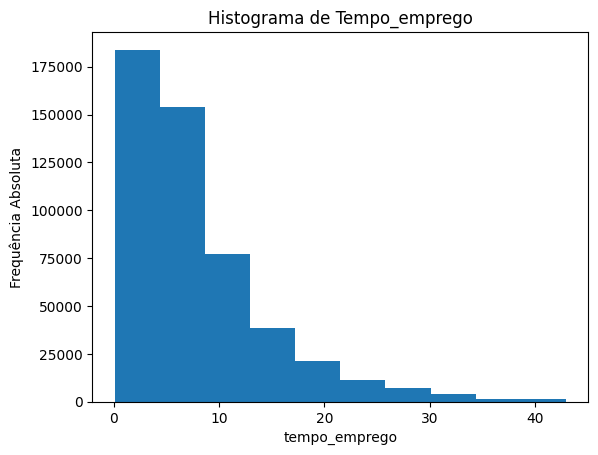

               qt_pessoas_residencia
Contagem               600000.000000
Média                       2.212122
Desvio_Padrão               0.903757
Valor_Mínimo                1.000000
25%                         2.000000
50%                         2.000000
75%                         3.000000
Valor_Máximo               15.000000


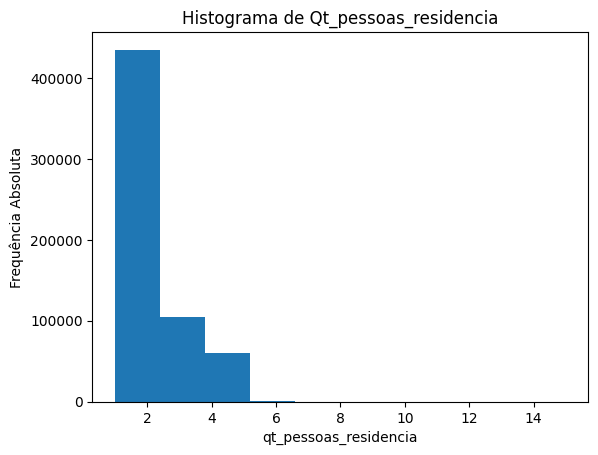

                      renda
Contagem       6.000000e+05
Média          2.722284e+04
Desvio_Padrão  8.737788e+04
Valor_Mínimo   1.618600e+02
25%            4.670600e+03
50%            9.887580e+03
75%            2.162887e+04
Valor_Máximo   4.083986e+06


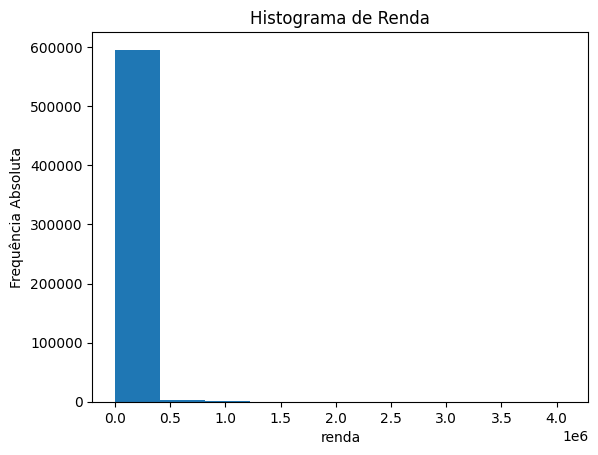

                         mes
Contagem       600000.000000
Média               6.500000
Desvio_Padrão       3.452055
Valor_Mínimo        1.000000
25%                 3.750000
50%                 6.500000
75%                 9.250000
Valor_Máximo       12.000000


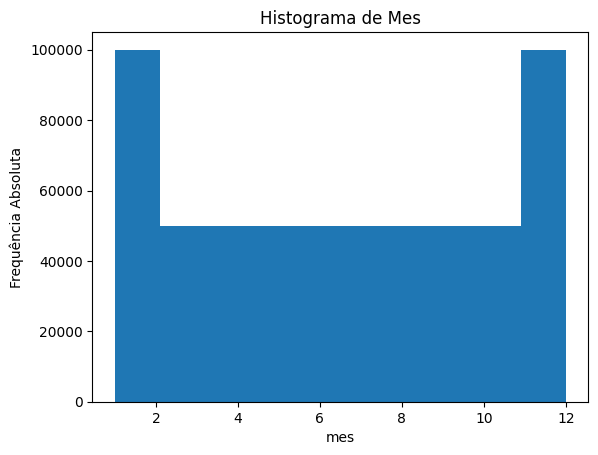

In [7]:
# Conduzindo análise univariada
for col in df_train.drop(['data_ref', 'index', 'mau'], axis=1):
    analise_univariada(df_train, col)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [8]:
# Criando dataframe com metadados
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['num_missing'] = df_train.isna().sum()
metadados['num_classes'] = df_train.nunique()
metadados['papel'] = 'independente'
metadados.loc['mau','papel'] = 'dependente'

metadados

,dtype,num_missing,num_classes,papel
data_ref,datetime64[ns],0,12,independente
index,int64,0,16650,independente
sexo,object,0,2,independente
posse_de_veiculo,object,0,2,independente
posse_de_imovel,object,0,2,independente
qtd_filhos,int64,0,8,independente
tipo_renda,object,0,5,independente
educacao,object,0,5,independente
estado_civil,object,0,5,independente
tipo_residencia,object,0,6,independente


In [9]:
# Corrigindo missings

df_train.ffill(inplace=True)
metadados['num_missing'] = df_train.isna().sum()

metadados

,dtype,num_missing,num_classes,papel
data_ref,datetime64[ns],0,12,independente
index,int64,0,16650,independente
sexo,object,0,2,independente
posse_de_veiculo,object,0,2,independente
posse_de_imovel,object,0,2,independente
qtd_filhos,int64,0,8,independente
tipo_renda,object,0,5,independente
educacao,object,0,5,independente
estado_civil,object,0,5,independente
tipo_residencia,object,0,6,independente


In [ ]:
# Função para calcular Information Value
def calcular_IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento] / tab.loc['total', rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento] / tab.loc['total', rótulo_nao_evento]
    
    tab['woe'] = np.log(tab.pct_evento / tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento) * tab.woe
    
    return tab['iv_parcial'].sum()   

iv = {}

for var in df_train.drop(['data_ref', 'index', 'mau'], axis=1):
    if df_train[var].dtype != 'object' and df_train[var].nunique() >= 6:
        iv[var] = calcular_IV(pd.qcut(df_train[var], 5, duplicates='drop'), df_train['mau'])
    else: 
        iv[var] = calcular_IV(df_train[var], df_train['mau'])

iv = pd.Series(iv).sort_values(ascending=False)

In [ ]:
# Visualizando Information Value das variáveis
iv

In [ ]:
# Classificando variáveis por IV
def classificar_IV(iv):
    if iv < 0.02:
        return 'Inútil'
    elif 0.02 < iv <= 0.1:
        return 'Fraco'
    elif 0.1 <= iv < 0.3:
        return 'Moderado'
    elif 0.3 <= iv < 0.5:
        return 'Forte'
    elif iv >= 0.5:
        return 'Overfitting'

# Criando nova coluna em metadados com IV e sua respectiva classificação
metadados = pd.concat([metadados, pd.DataFrame({'IV': iv, 'Classificação': iv.apply(classificar_IV)})], axis=1)
metadados

In [ ]:
# Funções para análise bivariada
def analise_bivariada(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var, observed=False)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel('Weight of Evidence')
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()

    plt.tight_layout()
    return biv

In [ ]:
analise_bivariada('sexo', df_train)

In [ ]:
analise_bivariada('posse_de_veiculo', df_train)

In [ ]:
analise_bivariada('posse_de_imovel', df_train)

In [ ]:
analise_bivariada('qtd_filhos', df_train)

In [ ]:
analise_bivariada('tipo_renda', df_train)

In [ ]:
analise_bivariada('educacao', df_train)

In [ ]:
analise_bivariada('estado_civil', df_train)

In [ ]:
analise_bivariada('tipo_residencia', df_train)

In [ ]:
df_train['cat_idade'] = pd.qcut(df_train['idade'], 5, duplicates='drop', labels=['Entre 22 e 33', 'Entre 33 e 40', 'Entre 40 e 47', 'Entre 47 e 55', 'Entre 55 e 68'])
analise_bivariada('cat_idade', df_train)

In [ ]:
df_train['cat_tempo_emprego'] = pd.qcut(df_train['tempo_emprego'], 12, duplicates='drop', labels=['(6.047, 7.178]', '(4.019, 4.885]', '(0.11699999999999999, 1.077]', 
                                                                  '(10.178, 13.186]', '(7.178, 8.518]', '(18.14, 42.907]', '(8.518, 10.178]', 
                                                                  '(13.186, 18.14]', '(4.885, 6.047]', '(1.077, 1.962]', '(1.962, 3.047]', 
                                                                  '(3.047, 4.019]'])
analise_bivariada('cat_tempo_emprego', df_train)

In [ ]:
analise_bivariada('qt_pessoas_residencia', df_train)

In [ ]:
df_train['cat_qt_pessoas_residencia'] = pd.qcut(df_train['qt_pessoas_residencia'], 5, duplicates='drop', 
                                                labels=['1 a 2 pessoas', '2 a 3 pessoas', '3 a 15 pessoas'])

analise_bivariada('cat_qt_pessoas_residencia', df_train)

In [ ]:
analise_bivariada('mes', df_train)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
# Vendo variáveis mais importantes
metadados.sort_values(by='IV', ascending=False)

In [ ]:
variaveis = ' + '.join(df_train.drop(['data_ref', 'index', 'mau', 
                                      'bom', 'renda', 'tipo_renda','educacao', 
                                      'estado_civil', 'tipo_residencia', 
                                      'cat_idade', 'cat_qt_pessoas_residencia', 
                                      'qtd_filhos', 'idade', 'qt_pessoas_residencia', 
                                      'cat_tempo_emprego', 'cat_renda'], axis=1).columns)

formula = 'mau ~ {}'.format(variaveis)

model = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

model.summary()

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
df_train['score'] = model.predict(df_train)
df_test['score'] = model.predict(df_test)

df_test.ffill(inplace=True)

# Acurácia
acc_train = metrics.accuracy_score(df_train['mau'], df_train['score'] > .068)
acc_test = metrics.accuracy_score(df_test['mau'], df_test['score'] > 0.68)

#AUC
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_test = metrics.auc(fpr_test, tpr_test)

#Gini
gini_train = 2*auc_train -1
ks_train = ks_2samp(df_train.loc[df_train['mau'] == 1, 'score'], df_train.loc[df_train['mau'] != 1, 'score']).statistic

gini_test = 2*auc_test -1
ks_test = ks_2samp(df_test.loc[df_test['mau'] == 1, 'score'], df_test.loc[df_test['mau'] != 1, 'score']).statistic

print('Modelo Testado na Base de Treino:')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc_train, auc_train, gini_train, ks_train))
print('='*50)
print('Modelo Testado na Base de Teste:')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc_test, auc_test, gini_test, ks_test))